In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,  Dropout, Dense, Activation, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import itertools

# Purpose of this NoteBook

This notebook presents a simple example of using keras embedding in the collaborative filtering recommender system. 

It displays the process of embedding and layer merge.

It also shows the process of building a recommender system using the simple dataset.

### Create a Dataframe 
The table includes reviewer_id, movie_id, and ratings for each movie per reviewer

    records = 20

    the number of unique reviewers is 10

    the number of unique movies is 6 


In [3]:
d = {"reviewer_id": ['r_01', 'r_01', 'r_01', 'r_02', 'r_03', 'r_04', 'r_04', 'r_05', 'r_06', 'r_07', 'r_07', 'r_07', 'r_08', 'r_08', 'r_09', 'r_10', 'r_10', 'r_10', 'r_10', 'r_10'],
    "movie_id":     ['m_01', 'm_03', 'm_04', 'm_05', 'm_01', 'm_02', 'm_04', 'm_01', 'm_03', 'm_03', 'm_04', 'm_06', 'm_02', 'm_03', 'm_05', 'm_01', 'm_03', 'm_04', 'm_05', 'm_06'],
    "rating": [4, 5, 2, 3, 4, 5, 2, 3, 4, 5,  4, 3, 4, 5, 2, 1, 4, 5, 3, 5]}

df=pd.DataFrame(d)

In [4]:
# the table
df.head()

,reviewer_id,movie_id,rating
0,r_01,m_01,4
1,r_01,m_03,5
2,r_01,m_04,2
3,r_02,m_05,3
4,r_03,m_01,4


In [5]:
df.describe(include='all')

,reviewer_id,movie_id,rating
count,20,20,20.000000
unique,10,6,NaN
top,r_10,m_03,NaN
freq,5,5,NaN
mean,NaN,NaN,3.650000
std,NaN,NaN,1.225819
min,NaN,NaN,1.000000
25%,NaN,NaN,3.000000
50%,NaN,NaN,4.000000
75%,NaN,NaN,5.000000


# Compare One Hot Encoding and Embedding

The following tables show the difference between One Hot Encoding and Embedding. As it shows below, embedding maps the discrete variable into a vector of continuous numbers (weights) that represent the learned space of each movie and reviewer. The weights are used to minimize the loss function in a nn and to calculate the similarity of the movies, and the reviewers.

In [6]:
ohe = OneHotEncoder(sparse = False)
ohe_reviewer = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df['reviewer_id'])), columns = ohe.get_feature_names())
ohe_movie = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df['movie_id'])), columns = ohe.get_feature_names())
df_1 = pd.concat([df, ohe_reviewer], axis = 1)
df_1 = pd.concat([df_1, ohe_movie], axis = 1)

In [43]:
## we can see that, after one hot encoding, the dimensions increase a lot. When we have one million reviewers, and movies, it is infeasible to run the model efficiently in this way. 
## Also, it does not show any relationship among the movies, and any relationship among reviewers 
df_1.head()

,reviewer_id,movie_id,rating,x0_r_01,x0_r_02,x0_r_03,x0_r_04,x0_r_05,x0_r_06,x0_r_07,x0_r_08,x0_r_09,x0_r_10,x0_m_01,x0_m_02,x0_m_03,x0_m_04,x0_m_05,x0_m_06
0,r_01,m_01,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,r_01,m_03,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,r_01,m_04,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,r_02,m_05,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,r_03,m_01,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Embedding Process
Embeddings are vector representations of an entity. Any discrete entity can be represented as a continuous space through Embeddings. Each item in the vector represents a feature or a combination of features for that entity.

Neural network embeddings have 3 primary purposes:

    1. Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.
    2. As input to a machine learning model for a supervised task.
    3. For visualization of concepts and relations between categories.

Embeddings are learned through a neural network on a supervised task. The embeddings form the parameters (weights) of the network which are adjusted to minimize loss on the task. The resulting embedded vectors are representations of categories where similar categories are closer to one another.

For example, embeddings can represent movies and user IDs in a three-demension space by assuming that these embeddings are three-dimensional vector. then We will create movie and user embeddings and train them along with a neural network. The goal is to bring users and movies in a similar embedding space so we can find the nearest ones based recommendation.

In [8]:
# label encoded movie_ID and reviewer_ID to sequential orders
df['reviewer'] = LabelEncoder().fit_transform(df['reviewer_id'].astype(str).values)
df['movie'] = LabelEncoder().fit_transform(df['movie_id'].astype(str).values)

In [9]:
# caulcaute the input dimensions for the embedding 
n_reviewers = df['reviewer'].nunique()
n_movies = df['movie'].nunique()
n_reviewers, n_movies

(10, 6)

In [14]:
reviewer_array = np.array(df['reviewer'].values)
movie_array = np.array(df['movie'].values)

In [15]:
reviewer_embedding = Embedding(input_dim=n_reviewers, output_dim=3, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(reviewer_array)

reviewer_embedding = Reshape((3,))(reviewer_embedding)
reviewer_embedding 

<tf.Tensor: shape=(20, 3), dtype=float32, numpy=
array([[-0.12281446,  0.80226237, -0.23804557],
       [-0.12281446,  0.80226237, -0.23804557],
       [-0.12281446,  0.80226237, -0.23804557],
       [-0.22821383, -0.2805468 ,  0.52490675],
       [ 0.5625861 ,  0.8573666 ,  0.11760359],
       [ 0.376415  ,  0.13599898, -0.01987142],
       [ 0.376415  ,  0.13599898, -0.01987142],
       [-0.35855636, -0.6867275 , -0.23761088],
       [ 0.59144694, -0.10350117, -0.11154537],
       [-0.61023414,  0.38328964,  0.49706146],
       [-0.61023414,  0.38328964,  0.49706146],
       [-0.61023414,  0.38328964,  0.49706146],
       [ 0.539804  ,  0.02265857, -0.58705366],
       [ 0.539804  ,  0.02265857, -0.58705366],
       [-0.5600027 ,  0.4082086 , -0.07202431],
       [-0.13465747,  0.31302387, -0.4028944 ],
       [-0.13465747,  0.31302387, -0.4028944 ],
       [-0.13465747,  0.31302387, -0.4028944 ],
       [-0.13465747,  0.31302387, -0.4028944 ],
       [-0.13465747,  0.31302387, -0.40

In [16]:
## movie embedding layer
movie_embedding = Embedding(input_dim=n_movies, output_dim=3, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(movie_array)
movie_embedding = Reshape((3,))(movie_embedding)
movie_embedding

<tf.Tensor: shape=(20, 3), dtype=float32, numpy=
array([[ 8.7716752e-01, -2.2328834e-01, -1.7630446e-01],
       [ 2.4359398e-01, -8.0818379e-01,  1.5827359e-01],
       [ 2.0876410e-04, -4.7512770e-01,  2.8327350e-02],
       [-1.9961014e-01,  1.5970682e-01, -9.2676781e-02],
       [ 8.7716752e-01, -2.2328834e-01, -1.7630446e-01],
       [ 7.2325878e-02, -6.8954742e-01,  1.2015628e+00],
       [ 2.0876410e-04, -4.7512770e-01,  2.8327350e-02],
       [ 8.7716752e-01, -2.2328834e-01, -1.7630446e-01],
       [ 2.4359398e-01, -8.0818379e-01,  1.5827359e-01],
       [ 2.4359398e-01, -8.0818379e-01,  1.5827359e-01],
       [ 2.0876410e-04, -4.7512770e-01,  2.8327350e-02],
       [ 6.3378817e-01,  8.1881531e-02,  2.9806212e-02],
       [ 7.2325878e-02, -6.8954742e-01,  1.2015628e+00],
       [ 2.4359398e-01, -8.0818379e-01,  1.5827359e-01],
       [-1.9961014e-01,  1.5970682e-01, -9.2676781e-02],
       [ 8.7716752e-01, -2.2328834e-01, -1.7630446e-01],
       [ 2.4359398e-01, -8.0818379e-01,

In [17]:
# Layer Merge: dot product of reviewer embedding layer and movie embedding layer into one dimension, which will be used as input layer (X) in the model. 
x = Dot(axes=1)([reviewer_embedding, movie_embedding])
x

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[-0.2448962 ],
       [-0.71596867],
       [-0.3879459 ],
       [-0.04789811],
       [ 0.28130826],
       [-0.09042995],
       [-0.06510121],
       [-0.11928387],
       [ 0.21006618],
       [-0.37974614],
       [-0.16815847],
       [-0.34055933],
       [-0.68196416],
       [ 0.02026562],
       [ 0.18365088],
       [-0.11697966],
       [-0.34955013],
       [-0.16016737],
       [ 0.11420999],
       [-0.07172219]], dtype=float32)>

## Split Data & Build Models

In [18]:
X = df[['reviewer', 'movie']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16, 2), (4, 2), (16,), (4,))

In [19]:
## transform the X variables into array because embedings are abstract representations of the features in numbers.
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## Build Base Model

The base model has only input layer and output layer. Does not have any hidden layer

In [20]:
def RecommenderV1(n_reviewers, n_movies, n_factors, loss, opt, metrics):
    reviewer = Input(shape=(1,))
    r = Embedding(n_reviewers, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(reviewer)
    r = Reshape((n_factors,))(r)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([r, m])
    model = Model(inputs=[reviewer, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model

In [21]:
loss='mean_squared_error'
opt = Adam(lr=0.001)
n_factors=50
metrics=['mae']

In [22]:
model = RecommenderV1(n_reviewers, n_movies,n_factors, loss, opt, metrics)

In [23]:
history = model.fit(x=X_train_array, 
                     y=y_train, 
                     batch_size=64, 
                     epochs=5,
                     verbose=1,
                     validation_data=(X_test_array, y_test))

Train on 16 samples, validate on 4 samples
Epoch 1/5


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16/16 [==============================] - 0s 21ms/sample - loss: 17.6350 - mae: 3.8845 - val_loss: 27.9111 - val_mae: 4.4436
Epoch 2/5
16/16 [==============================] - 0s 337us/sample - loss: 17.4048 - mae: 3.8573 - val_loss: 27.9301 - val_mae: 4.4457
Epoch 3/5
16/16 [==============================] - 0s 325us/sample - loss: 17.1763 - mae: 3.8301 - val_loss: 27.9490 - val_mae: 4.4478
Epoch 4/5
16/16 [==============================] - 0s 334us/sample - loss: 16.9496 - mae: 3.8029 - val_loss: 27.9678 - val_mae: 4.4500
Epoch 5/5
16/16 [==============================] - 0s 336us/sample - loss: 16.7248 - mae: 3.7756 - val_loss: 27.9867 - val_mae: 4.4521


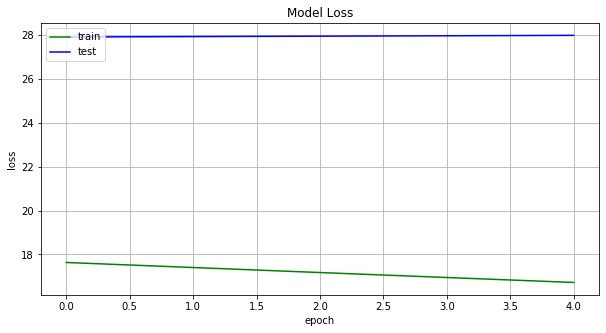

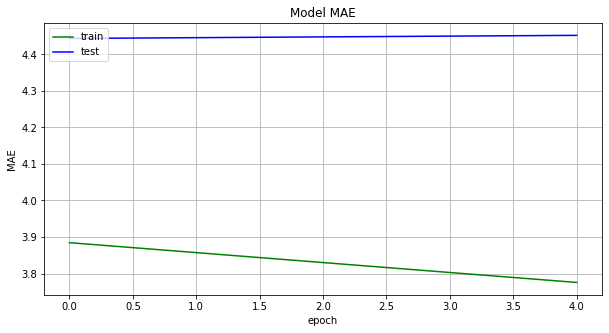

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['mae'] , 'g')
plt.plot(history.history['val_mae'] , 'b')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Improving Model

Add Hidden Layers
Change layer merge methods

In [25]:
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderNet(n_reviewers, n_movies, n_factors, min_rating, max_rating):
    reviewer = Input(shape=(1,))
    r = EmbeddingLayer(n_reviewers, n_factors)(reviewer)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([r, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[reviewer, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    return model

In [127]:
loss='mean_squared_error'
opt = Adam(lr=0.001)
n_factors=3
metrics=['mae']
min_rating=df['rating'].min()
max_rating=df['rating'].max()

In [128]:
model2 = RecommenderNet(n_reviewers, n_movies, n_factors, min_rating, max_rating)

In [139]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(
    log_dir='.\logs',
    histogram_freq=1,
    write_images=True)

keras_callbacks = [tensorboard]

history2 = model2.fit(x=X_train_array, 
                     y=y_train, 
                     batch_size=64, 
                     epochs=50,
                     verbose=1,
                     validation_data=(X_test_array, y_test),
                     callbacks=keras_callbacks)

Train on 16 samples, validate on 4 samples
Epoch 1/50
16/16 [==============================] - 0s 1ms/sample - loss: 1.2772 - mae: 0.9404 - val_loss: 3.0848 - val_mae: 1.7116
Epoch 2/50
16/16 [==============================] - 0s 1ms/sample - loss: 2.3206 - mae: 1.1014 - val_loss: 3.0766 - val_mae: 1.7088
Epoch 3/50
16/16 [==============================] - 0s 791us/sample - loss: 2.6624 - mae: 1.3446 - val_loss: 3.0693 - val_mae: 1.7062
Epoch 4/50
16/16 [==============================] - 0s 861us/sample - loss: 1.7063 - mae: 1.2210 - val_loss: 3.0628 - val_mae: 1.7039
Epoch 5/50
16/16 [==============================] - 0s 787us/sample - loss: 0.9737 - mae: 0.7772 - val_loss: 3.0573 - val_mae: 1.7019
Epoch 6/50
16/16 [==============================] - 0s 758us/sample - loss: 2.6462 - mae: 1.3016 - val_loss: 3.0514 - val_mae: 1.6995
Epoch 7/50
16/16 [==============================] - 0s 869us/sample - loss: 2.3437 - mae: 1.2489 - val_loss: 3.0448 - val_mae: 1.6969
Epoch 8/50
16/16 [=====

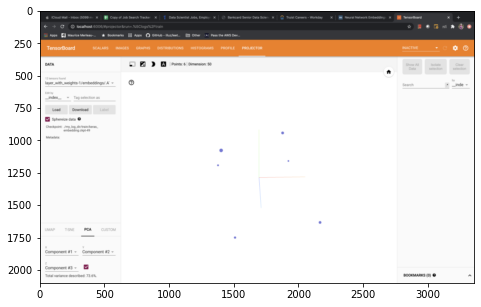

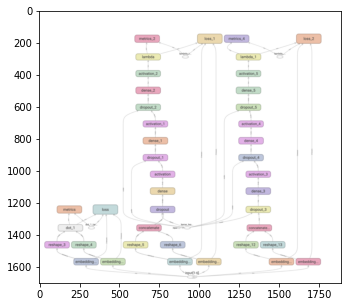

In [142]:
# in Terminal, run command: tensorboard --gdir . This will create a log and have all files in. Then find the localhost: http://localhost:6006/ 
# paste the localhost in a brower, then can see all the visualization in the tensorboard. I am still trying to figure out how to save the projectors. 

im = plt.imread('tensorboard.png')
# show the image 
plt.imshow(im,interpolation ='bilinear')
plt.show()
im_1 = plt.imread('main_graph.png')
plt.imshow(im_1,interpolation ='bilinear')
plt.show()

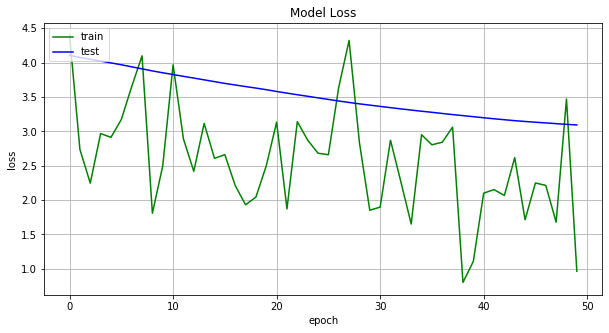

In [130]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'] , 'g')
plt.plot(history2.history['val_loss'] , 'b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

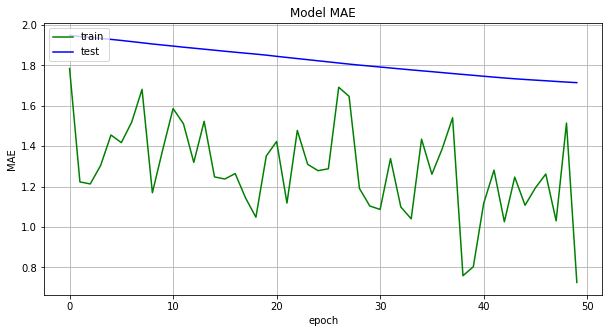

In [131]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history2.history['mae'] , 'g')
plt.plot(history2.history['val_mae'] , 'b')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Make a recommendation

Warning: Due to the model performance is really poor with a few data points, the results are not accurate.

In [132]:
## Recommend movies for reviewer with reviewer = any number frm 0 t0 9 

movie_data = np.array(list(set(df.movie)))
## select a user using user sequetial order
user = np.array([0 for i in range(len(movie_data))])
predictions = model2.predict([user, movie_data])
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:3]
print(recommended_movie_ids)
print(predictions[recommended_movie_ids])

[2 3 0]
[3.0976007 3.0682013 2.9644017]


In [133]:
recommend = df[df['movie'].isin(recommended_movie_ids)]
recommend = (recommend[['movie_id']]).drop_duplicates()
recommend

,movie_id
0,m_01
1,m_03
2,m_04
